<a href="https://colab.research.google.com/github/bharaniakella/Akellian_DL/blob/main/SGD_with_momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

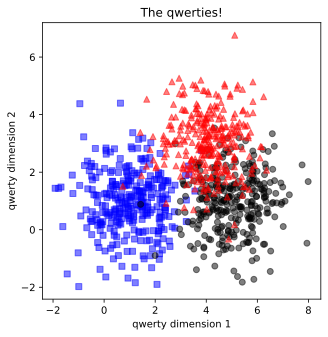

In [15]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [16]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)
train_data=TensorDataset(train_data,train_labels)
test_data=TensorDataset(test_data,test_labels)

train_loader=DataLoader(train_data,batch_size=16, shuffle=True, drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [17]:
def createQwertyNet(momentum):
  class QwertyNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.input=nn.Linear(2,8)
      self.fc1=nn.Linear(8,8)
      self.output=nn.Linear(8,3)

    def forward(self,x):
      x=F.relu(self.input(x))
      x=F.relu(self.fc1(x))
      x=self.output(x)
      return x
  net=QwertyNet()
  loss_fun=nn.CrossEntropyLoss()
  optimizer=torch.optim.SGD(net.parameters(),lr=0.01,momentum=momentum)

  return net, loss_fun, optimizer

In [18]:
torch.randn(10,2)
createQwertyNet(0.9)[2]

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [21]:
numepochs=50
def function2trainTheModel(momentum):
  trainAcc=[]
  testAcc=[]
  losses=torch.zeros(numepochs)
  net, loss_fun, optimizer=createQwertyNet(momentum)
  for epochi in range(numepochs):
    net.train()
    batchAcc=[]
    batchLoss=[]
    for x,y in train_loader:
      yhat=net(x)
      loss=loss_fun(yhat,y)



      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      batchLoss.append(loss.item())

      batchAcc.append(100*torch.mean((torch.argmax(yhat,axis=1)==y).float()).item())

    trainAcc.append(np.mean(batchAcc))
    losses[epochi]=np.mean(batchLoss)

    net.eval()
    x,y=next(iter(test_loader))

    with torch.no_grad():
      yhat=net(x)
      testAcc.append(100*torch.mean((torch.argmax(yhat,axis=1)==y).float()).item())

  return trainAcc,testAcc,losses,net





In [22]:
moments=[0,.5,.9,.95,.999]

results=np.zeros((numepochs,len(moments),3))

for idx,mom in enumerate(moments):
  trainAcc,testAcc,losses,net = function2trainTheModel(mom)
  results[:,idx,0] = losses
  results[:,idx,1] = trainAcc
  results[:,idx,2] = testAcc

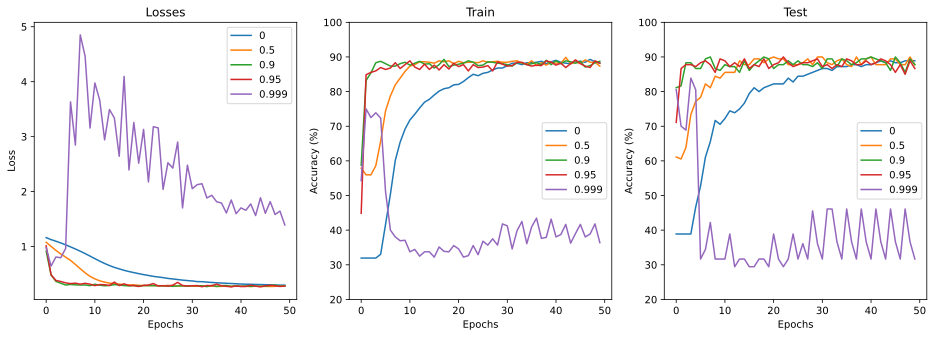

In [24]:
fig,ax = plt.subplots(1,3,figsize=(16,5))

for i in range(3):
  ax[i].plot(results[:,:,i])
  ax[i].legend(moments)
  ax[i].set_xlabel('Epochs')
  if i==0:
    ax[i].set_ylabel('Loss')
  else:
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([20,100])

ax[0].set_title('Losses')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()